In [1]:
# IMAGE PROCESSING
import cv2 # OpenCV library
import numpy as np # Numpy library for matricies
import random
import math
from matplotlib import pyplot as plt # Matplotlib library for plotting
from collections import deque
import heapq

random.seed(42)

In [2]:
# General settings
seed = 42
image_file = "obstacle_mask_1208.png"

# Occupancy map
unsafe_iterations = 3

# BFS
size_of_node_grid = 9
bfs_start_node = 0
bfs_end_node = 99


height: 2160
width: 3840
[[ 7.46268657e-01  5.96744876e-16 -3.20895522e+02]
 [-5.82867088e-16  7.39644970e-01 -1.96005917e+02]
 [-1.21972744e-19  5.08219768e-19  1.00000000e+00]]


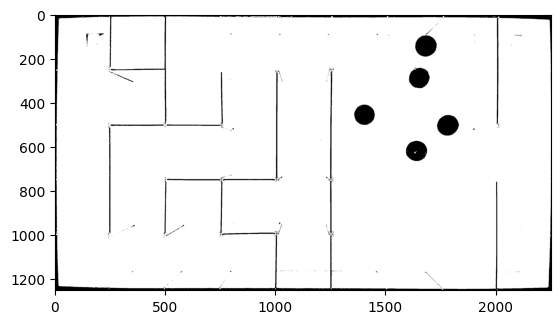

In [3]:
# perspective transform
image1 = cv2.imread(image_file)
height = image1.shape[0]
width = image1.shape[1]
print("height:", height)
print("width:", width)
pts1 = np.float32([[430,265],[3445,265],[430,1955],[3445,1955]]) # original img corners
pts2 = np.float32([[0,0],[2250,0],[0,1250],[2250,1250]]) # warped corners

H = cv2.getPerspectiveTransform(pts1,pts2) # homography matrix
print(H)

dst = cv2.warpPerspective(image1, H, (2251,1251)) # 250*9 x 250*5
plt.imshow(dst)
plt.show()


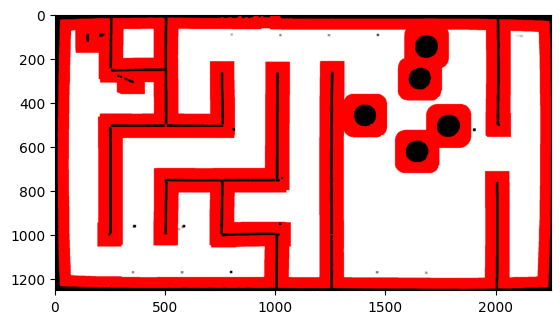

In [4]:
# Applying Erosion + Dilation to the Image
# def generate_buffer_zone(img, kernels, iteration):
#     kernel = np.ones((kernels, kernels), np.uint8)
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     _, obstacle = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV)
#     unsafe_zone = cv2.dilate(obstacle, kernel, iterations=iteration)
#     unsafe_mask = np.logical_and(unsafe_zone == 255, obstacle == 0)
#     img[unsafe_mask] = [255, 0, 0]    
#     return img

# added minimum obstacle size to skip over the noise when buffering
def generate_buffer_zone(img, kernels, iteration, minObs):
    kernel = np.ones((kernels, kernels), np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, obstacle = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(obstacle, connectivity=8)
    large_obstacles_mask = np.zeros_like(obstacle)
    for i in range(1, num_labels):  
        if stats[i, cv2.CC_STAT_AREA] > minObs:
            large_obstacles_mask[labels == i] = 255
    unsafe_zone = cv2.dilate(large_obstacles_mask, kernel, iterations=iteration)
    unsafe_mask = np.logical_and(unsafe_zone == 255, obstacle == 0)
    img[unsafe_mask] = [255, 0, 0]  
    return img

kernel = np.ones((7, 7), np.uint8)
kernel3 = np.ones((3, 3), np.uint8)
kernel4 = np.ones((2, 2), np.uint8)
    
# Loading in the image
image = dst.copy()
# hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# lower = np.array([8, 0, 119]) # 0 0 102
# upper = np.array([97, 255, 255]) # 179 255 224

# hsv_mask = cv2.inRange(hsv_image, lower, upper)

# Applying erosion to generate unsafe area
# eroded_image = cv2.erode(image, kernel, iterations = unsafe_iterations)

kernel2 = np.ones((4, 4), np.uint8)
kernel5 = np.ones((1, 1), np.uint8)

# Applying dilation to clean up the image
dilated_image = cv2.dilate(image, kernel4, iterations = 2)
# dilated_image2 = cv2.dilate(dilated_image, kernel3, iterations = 2)
erode_image2 = cv2.erode(dilated_image, kernel2, iterations = 3)

buffer_image = generate_buffer_zone(erode_image2,100,1,300)
# dilTE123 = cv2.dilate(erode_image2,kernel4,iterations = 2)
# erode123 = cv2.erode(dilTE123,kernel4,iterations = 4)
# dilate12 = cv2.dilate(erode123,kernel4,iterations = 1)
# dilate13 = cv2.dilate(dilate12,kernel3,iterations = 1)
# dilate14 = cv2.dilate(dilate13,kernel4,iterations = 1)
# # dilate15 = cv2.dilate(dilate14,kernel4,iterations = 1)
# dilate16 = cv2.dilate(dilate14,kernel4,iterations = 1)
# erode123456 = cv2.erode(dilate16,kernel,iterations = 2)
# dilate16767 = cv2.dilate(erode123456,kernel,iterations = 2)
# erodeABCD = cv2.erode(dilate16767,kernel4,iterations = 2)
# DILATELAST = cv2.dilate(erodeABCD,kernel3,iterations = 1)

# FINALERODE = cv2.erode(DILATELAST,kernel,iterations = 3)
# dilatelast2 = cv2.dilate(FINALERODE,kernel,iterations = 3)
# FINALERODE2 = cv2.erode(dilatelast2,kernel3,iterations = 2)
# dilatelast3 = cv2.dilate(FINALERODE2,kernel3,iterations = 1)
# # dilatelast4 = 
# FINALERODE3 = cv2.erode(dilatelast3,kernel,iterations = 1)
# finaldilate = cv2.dilate(FINALERODE3, kernel, iterations = 1)
# lasttterode = cv2.erode(finaldilate,kernel4,iterations = 3)
# Displays resulting image

# Displays resulting image
plt.imshow(buffer_image)
plt.show()


In [5]:
class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x, self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {} # Keys are node IDs, Values are node objects
        self.edges = {} # Keys are node IDs, Values are objects containing neighbouring node ID and the weight

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)
            self.edges[node_id] = {}

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            # Edges are bi-directional
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight

    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            # Edges are bi-directional
            del self.edges[node_id1][node_id2]
            del self.edges[node_id2][node_id1]
    
    def get_nodes(self):
        return list(self.nodes.keys())
    
    def get_edge_weight(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            return self.edges[node_id1][node_id2]
        return None
    
    def get_nodes_dict(self):
        return self.nodes
    
    def get_edges_dict(self):
        return self.edges


In [6]:
def path_clear(image,x1, y1, x2, y2):
    num_points = int(np.hypot(x2 - x1, y2 - y1)) + 1
    for i in range(num_points):
        t = i / num_points
        x = int(x1 + t * (x2 - x1))
        y = int(y1 + t * (y2 - y1))
        if not (0 <= x < image.shape[1] and 0 <= y < image.shape[0]):
            return False  
        if np.array_equal(image[y,x], [255, 0, 0]) or np.array_equal(image[y,x], [0, 0, 0]):
            return False
    return True

def find_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def prm_path_clear(image, x1, y1, x2, y2):
    
    distance = int(round(find_distance(x1, y1, x2, y2)))
    
    x_points = np.linspace(x1, x2, distance)
    y_points = np.linspace(y1, y2, distance)
    
    x_points = np.round(x_points).astype(int)
    y_points = np.round(y_points).astype(int)
    
    last_val = None
    for x, y in zip(x_points, y_points):
        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            if last_val is None:
                last_val = image[y, x].any()
            else:
                if last_val != image[y, x].any():
                    return False
                else: 
                    last_val = image[y, x].any()

    return True

def find_neighbours(graph, node_id):
    neighbours = []
    nodes = graph.get_nodes()
    for node in nodes:
        print('4')
        if graph.get_edge_weight(node_id, node) is not None and node != node_id:
            neighbours.append(node_id)
    return neighbours

def dijkstra(graph, start_id, goal_id):
    queue = [(0, start_id)]
    distances = {node.get_ID(): float('inf') for node in list(graph.get_nodes_dict().values())}
    distances[start_id] = 0
    parent = {node.get_ID(): None for node in list(graph.get_nodes_dict().values())}
    while queue:
        current_distance, current_id = heapq.heappop(queue)        
        if current_id == goal_id:
            break       
        for neighbor_id, weight in graph.edges[current_id].items():
            distance = current_distance + weight            
            if distance < distances[neighbor_id]:
                distances[neighbor_id] = distance
                parent[neighbor_id] = current_id
                heapq.heappush(queue, (distance, neighbor_id))    
    path = []
    current_id = goal_id
    while parent[current_id] is not None:
        path.insert(0, current_id)
        current_id = parent[current_id]
    path.insert(0, start_id)   
    return path, distances[goal_id]


[9, 36, 37, 19, 21, 3, 45, 49, 60, 57, 23, 64, 26, 35]
['t90.0', 'f750.0', 't90.0', 'f250.0', 't90.0', 'f500.0', 't-90.0', 'f500.0', 't90.0', 'f500.0', 't-90.0', 'f375.0', 't-45.0', 'f176.7766952966369', 't0.0', 'f176.7766952966369', 't0.0', 'f176.7766952966369', 't-108.434948822922', 'f279.5084971874737', 't126.869897645844', 'f279.5084971874737', 't40.60129464500447', 'f515.3882032022076', 't-104.03624346792648', 'f250.0']


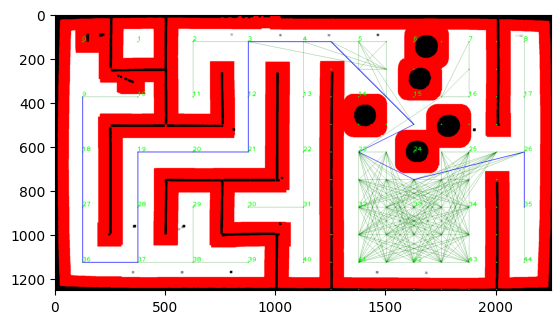

In [33]:
grid_image = buffer_image.copy()
# grid_image = cv2.cvtColor(erode123, cv2.COLOR_HSV2BGR)
height = grid_image.shape[1]
width = grid_image.shape[0]
# node_spacing_x = (width // (size_of_node_grid + 1))
# node_spacing_y = (height // (size_of_node_grid + 1))

x_nodes = 9 #9 18
y_nodes = 5 #5 10

node_spacing_x = width // (x_nodes + 1)
node_spacing_y = height // (y_nodes + 1)

# spacing right now is hard coded, need to watch out if the camera shifts or anything when taking photo

custom_node_spacing_y = 250 #250 125
custom_node_spacing_x = 2250 // 9 #9 18

bfs_graph = Graph()

# The following loops were generated with the help of ChatGPT:]

node_id = 0
for i in range(y_nodes):
    for j in range(x_nodes):
        x = 125 + j * custom_node_spacing_x
        y = 125 + i * custom_node_spacing_y
         
        bfs_graph.add_node(node_id, x, y)
        node_id += 1

for i in range(y_nodes * 2):
    for j in range(4):
        x = custom_node_spacing_x * (5 + j)
        y = 125 + i * int(custom_node_spacing_y // 2)
        
        bfs_graph.add_node(node_id, x, y)
        node_id += 1

    for j in range(3):
        x = custom_node_spacing_x * (5 + j) + 125
        # y = 125 + i * int(custom_node_spacing_y // 2)
        y = 125 + int(custom_node_spacing_y // 2) + i * custom_node_spacing_y
        
        bfs_graph.add_node(node_id, x, y)
        node_id += 1


# Creating nodes
# node_id = 0
# for i in range(1, size_of_node_grid + 1):
#     for j in range(1, size_of_node_grid + 1):
#         x = j * node_spacing_x
#         y = i * node_spacing_y
         
#         bfs_graph.add_node(node_id, x, y)
#         node_id += 1

# # Adding edges
# for i in range(size_of_node_grid):
#     for j in range(size_of_node_grid):
#         current_node_id = i * size_of_node_grid + j
#         x, y = bfs_graph.nodes[current_node_id].get_point()
#         # Connecting to the right with a weight of 1
#         if j + 1 < size_of_node_grid:
#             right_node_id = current_node_id + 1
#             if path_clear(grid_image, x, y, x + node_spacing_x, y):
#                 bfs_graph.add_edge(current_node_id, right_node_id, 1)
#         # Connecting down with a weight of 1
#         if i + 1 < size_of_node_grid:
#             down_node_id = current_node_id + size_of_node_grid
#             if path_clear(grid_image, x, y, x, y + node_spacing_y):
#                 bfs_graph.add_edge(current_node_id, down_node_id, 1)

nodes = bfs_graph.get_nodes()


for node_id in nodes:
    node_x, node_y = bfs_graph.nodes[node_id].get_point()
#     if node_id + 1 in nodes and node_id not in [8, 17, 26, 35, 44] != 0:
#         right_node_x, right_node_y = bfs_graph.nodes[node_id + 1].get_point()
#         if prm_path_clear(grid_image, node_x, node_y, right_node_x, right_node_y):
#             bfs_graph.add_edge(node_id, node_id + 1, 1)
#     if node_id + 9 in nodes:
#         down_node_x, down_node_y = bfs_graph.nodes[node_id + 9].get_point()
#         if prm_path_clear(grid_image, node_x, node_y, down_node_x, down_node_y):
#             bfs_graph.add_edge(node_id, node_id + 9, 1)
#     colNum = (node_x - 125) / custom_node_spacing_x
#     if colNum not in list(range(10, 17)):
#         if node_id > 18:
#             node_above = node_id - 18
#             node_above_x, node_above_y = bfs_graph.nodes[node_above].get_point()
#             if prm_path_clear(grid_image, node_x, node_y, node_above_x, node_above_y) and path_clear(grid_image, node_x, node_y, node_above_x, node_above_y):
#                 bfs_graph.add_edge(node_id, node_above, find_distance(node_x, node_y, node_above_x, node_above_y))
#         if colNum != 0:
#             node_left = node_id - 1
#             node_left_x, node_left_y = bfs_graph.nodes[node_left].get_point()
#             if prm_path_clear(grid_image, node_x, node_y, node_left_x, node_left_y) and path_clear(grid_image, node_x, node_y, node_left_x, node_left_y):
#                 bfs_graph.add_edge(node_id, node_above, find_distance(node_x, node_y, node_left_x, node_left_y))
#     else: 
    for node_id_2 in nodes:
        if node_id_2 == node_id:
            continue
        node_2_x, node_2_y = bfs_graph.nodes[node_id_2].get_point()
        if prm_path_clear(grid_image, node_x, node_y, node_2_x, node_2_y) and path_clear(grid_image, node_x, node_y, node_2_x, node_2_y):
                bfs_graph.add_edge(node_id, node_id_2, find_distance(node_x, node_y, node_2_x, node_2_y))

# Displaying nodes as light green circles with radius 3
for node_id in bfs_graph.get_nodes():
    node_obj = bfs_graph.nodes[node_id]
    x,y = node_obj.get_point();
    cv2.circle(grid_image, node_obj.get_point(), 3, (0, 255, 0), -1)

# Displaying edges as dark green lines with width 1
for node_id in bfs_graph.get_nodes():
    for neighbour_id, weight in bfs_graph.edges[node_id].items():
        node_obj = bfs_graph.nodes[node_id]
        neighbour_obj = bfs_graph.nodes[neighbour_id]
        cv2.line(grid_image, node_obj.get_point(), neighbour_obj.get_point(), (0, 125, 0), 1)

# Labeling first and last nodes
# cv2.putText(grid_image, '0', bfs_graph.nodes[0].get_point(), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
# cv2.putText(grid_image, '99', bfs_graph.nodes[size_of_node_grid*size_of_node_grid - 1].get_point(), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# continuous part starts on the 6th column and ends on the 9th

# nodes: 5 + 9... 

continuous_start = list(range(5, 42, 9))

# for i in continuous_start:
#     path, cost = dijkstra(bfs_graph, 0, i)
#     if path:
#         for node in path: 
#             if node in continuous_start and node != path[-1]:
#                 # if a valid path is found, but the path goes through the continuous start, don't use this path
#                 # and keep searching for a path that starts at tge continuous part
#                 continue
#         break

path, cost = dijkstra(bfs_graph, 9, 35)
# path, cost = dijkstra(bfs_graph, 18, 160)

print(path)

# converting path to commands
# looking at our code right now, i think there are 2 options
# 1. make the turning function be able to turn to any orientation (need it for continuous planning anyways),
#    then we can just call move forward and turn to whatever orientation we need
# 2. if we want to keep the maze movement as just forward, left and right then we'd need to keep track of 
#    the robots current orientation

# could try 2 since its simpler rn and we alr have turn left turn right
# for 2: 
# could identify 0, 1, 2, 3 as forward, right, down, left from the robot's current orientation, then
# keep track of the robot's current orientation and do (turn direction = global direction - current orientation)
# e.g. say robot's facing down (2), and the next path is right (1), then 1 - 2 = -1 + 4 = 3 therefore need to 
#      turn left

# + 4 if negative until positive

# now we have to consider that the dijkstra paths don't just go to the nearest node in the maze, it goes to the 
# cheapest one so it might jump directly

commands = []

# 0: up
# 1: right
# 2: down
# 3: left
# from perspective of camera

start_dir = 3

if start_dir == 0:
    curr_angle = 90.0
elif start_dir == 1: 
    curr_angle = 0.0 
elif start_dir == 2: 
    curr_angle = -90.0
elif start_dir == 3: 
    curr_angle = 180.0

# for i in range(1, len(path)):
#     last_node = bfs_graph.nodes[path[i - 1]]
#     curr_node = bfs_graph.nodes[path[i]]
#     cv2.line(grid_image, curr_node.get_point(), last_node.get_point(), (0, 0, 255), 2)
    
#     if curr_node.get_point()[0] - last_node.get_point()[0] < 0:
#         global_dir = 3
#     elif curr_node.get_point()[0] - last_node.get_point()[0] > 0:
#         global_dir = 1
#     elif curr_node.get_point()[1] - last_node.get_point()[1] < 0: 
#         global_dir = 0
#     elif curr_node.get_point()[1] - last_node.get_point()[1] > 0: 
#         global_dir = 2
        
#     if i == 1: 
#         last_dir = start_dir
#     else: 
#         if bfs_graph.nodes[path[i-1]].get_point()[0] - bfs_graph.nodes[path[i-2]].get_point()[0] < 0:
#             last_dir = 3
#         elif bfs_graph.nodes[path[i-1]].get_point()[0] - bfs_graph.nodes[path[i-2]].get_point()[0] > 0:
#             last_dir = 1
#         elif bfs_graph.nodes[path[i-1]].get_point()[1] - bfs_graph.nodes[path[i-2]].get_point()[1] < 0: 
#             last_dir = 0
#         elif bfs_graph.nodes[path[i-1]].get_point()[1] - bfs_graph.nodes[path[i-2]].get_point()[1] > 0: 
#             last_dir = 2
    
#     next_dir = global_dir - last_dir
    
#     if next_dir < 0: 
#         next_dir += 4

#     # t for turn, f for forward

#     if next_dir == 1: 
#         commands.append('r')
#     elif next_dir == 2: 
#         commands.append('rr')
#     elif next_dir == 3:
#         commands.append('l')
#     commands.append(str(find_distance(curr_node.get_point()[0], curr_node.get_point()[1], last_node.get_point()[0], last_node.get_point()[1])))

for i in range(1, len(path)):
    last_node = bfs_graph.nodes[path[i - 1]]
    curr_node = bfs_graph.nodes[path[i]]
    cv2.line(grid_image, curr_node.get_point(), last_node.get_point(), (0, 0, 255), 2)
    
    # -1 * (curr_y - last_y) as the y axis is inverted
    angle = math.degrees(math.atan2(-1 * (curr_node.get_point()[1] - last_node.get_point()[1]), curr_node.get_point()[0] - last_node.get_point()[0]))
    
    turn_angle = angle - curr_angle
    # CHECK IF THE CODE BELOW WORKS
    if turn_angle < -180:
        turn_angle += 360
    elif turn_angle > 180:
        turn_angle -= 360
    ##################

    curr_angle = angle

    # t for turn, f for forward
    
    commands.append('t' + str(turn_angle))
    commands.append('f' + str(find_distance(curr_node.get_point()[0], curr_node.get_point()[1], last_node.get_point()[0], last_node.get_point()[1])))


print(commands)

with open('output.txt', 'w+') as f:
    f.write(str(commands))
    f.close()

last_node_index = x_nodes * y_nodes
for i in range(last_node_index):
    last_node_x, last_node_y = bfs_graph.nodes[i].get_point()
    cv2.putText(grid_image, str(i), (last_node_x - 3, last_node_y - 3), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
# Displaying resulting image
plt.imshow(grid_image)
plt.show()